# Python for Data Science Project

### Nathan W. Van Bibber

I worked on this project by myself.
***

## Palmer Penguins

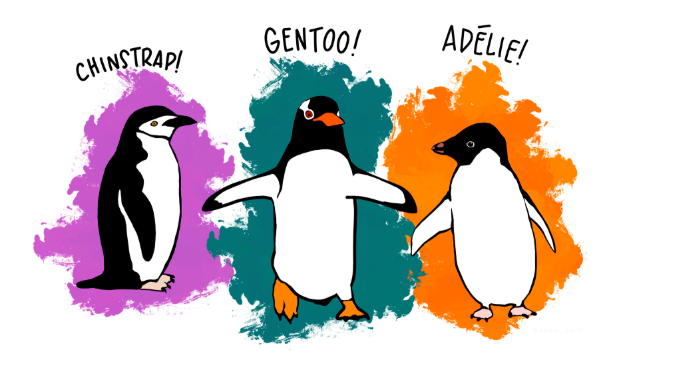
Artwork by @allison_horst

## Part 1: Predict Species (classification)
### Step-1 Problem Definition:   

The Palmer penguin dataset is a relatively new dataset intended as an alternative to the overused iris dataset. The dataset contains anatomical measurements and observations on three species of penguins from the Palmer Archipelago, Antarctica. I will use classification to try to predict the species of penguin based on the other characteristics. Also, I will use regression to predict penguin body mass.

There is a simplified dataset available in the Seaborn library, `sns.load_dataset('penguins')`, but to get practice with data cleaning a processing I will get the data directly from the Environmental Data Initiative website.

In [2]:
import pandas as pd
import numpy as np

# Get data directly from the Environmental Data Initiative
# Adelie penguin data from: https://doi.org/10.6073/pasta/abc50eed9138b75f54eaada0841b9b86
url_adelie = "https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.219.3&entityid=002f3893385f710df69eeebe893144ff"

# Gentoo penguin data from: https://doi.org/10.6073/pasta/2b1cff60f81640f182433d23e68541ce
url_gentoo = "https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.220.3&entityid=e03b43c924f226486f2f0ab6709d2381"

# Chinstrap penguin data from: https://doi.org/10.6073/pasta/409c808f8fc9899d02401bdb04580af7
url_chinstrap = "https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.221.2&entityid=fe853aa8f7a59aa84cdd3197619ef462"

# Combining the URLs into a list
urls = [url_adelie, url_gentoo, url_chinstrap]

# Read each of the csv files in the list.
list_penguins = [pd.read_csv(u) for u in urls]

# Concatenate all of the data together
penguins_df = pd.concat(list_penguins, ignore_index=True)

# save df to csv incase I can't access urls later
# penguins_df.to_csv('Penguins.csv')

print(penguins_df.shape)
penguins_df.head(3)

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN


### Step-2: Data Cleaning and Preprocessing:  
In this step, you must identify the relevant columns in the dataset that can be used as predictors. Any irrelevant data columns must be excluded from the analysis. If there are any missing values in the dataset, they should be replaced through a data imputation method. Any missing rows should be deleted from the dataset. Each column data type must be converted into an appropriate data type. The data types can be obtained either in data info files or can be determined by inspection.  

#### Inspect data

In [4]:
penguins_df.nunique()

studyName                3
Sample Number          152
Species                  3
Region                   1
Island                   3
Stage                    1
Individual ID          190
Clutch Completion        2
Date Egg                50
Culmen Length (mm)     164
Culmen Depth (mm)       80
Flipper Length (mm)     55
Body Mass (g)           94
Sex                      3
Delta 15 N (o/oo)      330
Delta 13 C (o/oo)      331
Comments                10
dtype: int64

#### Rermove irrelevant columns
I will remove the following columns because I think they are irrelevant to either of my prediction problems:

`studyName`, `Sample Number`, `Region`, `Stage`, `Individual ID`, `Clutch Completion`, `Date Egg`, `Comments`

I will also simplify the species column by extracting only the common name for each species.  Then I will rename the columns.

In [5]:
# drop irrelevant columns
df = penguins_df.drop(['studyName', 'Sample Number', 'Region', 'Stage',
       'Individual ID', 'Clutch Completion', 'Date Egg', 'Comments'], axis=1)

# extract only the species common name from Species column
species_name = df[['Species']].applymap(lambda x: x.split()[0])
df.insert(1,"species",species_name)
df.drop("Species", axis=1, inplace=True)

# rename column names
col_names = ['species', 'island', 'culmen_length_mm', 'culmen_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'delta_15N_ppt', 'delta_13C_ppt']
df.columns = col_names


I may want the radio isotope columns (`delta_15N_ppt`, `delta_13C_ppt`) for later analyses, but I remove them for the classification model.

In [6]:
df_clean = df.drop(['delta_15N_ppt', 'delta_13C_ppt'], axis=1)
df_clean.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


#### Impute missing values

In [7]:
# check for missing values
df_clean.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [8]:
df_clean[df_clean['sex'].isna()]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
178,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
218,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
256,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
271,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


Two specimens (3 and 271) are missing data for every factor except `species` and `island` so I will drop them from the dataset. Then I will impute values for the 8 remaining specimens missing a value for `sex`.

In [9]:
df_clean.drop([3,271], inplace=True)
df_clean.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  8
dtype: int64

In [10]:
df_clean.sex.value_counts()

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64

In [11]:
df_clean.sex.unique() 

array(['MALE', 'FEMALE', nan, '.'], dtype=object)

It looks like one specimen has a typo in the `sex` column! I will change `'.'` to `NaN`.  Since there are almost equal numbers of males and females in the dataset, I will impute missing values by randomly selecting a sex for each one.

In [12]:
import numpy as np
df_clean.loc[df_clean['sex']=='.','sex'] = np.nan

In [13]:
np.random.seed(5)
# create a list of 9 random sex values
nan_impute = np.random.choice(['MALE','FEMALE'], size=9)
# make a list of the index of the missing values
nan_index = df_clean[df_clean['sex'].isna()].index.tolist()
# assign the list of random values using nan_index (side note using fillna might have been easier)
df_clean.loc[df_clean['sex'].isna(), 'sex'] = nan_impute

df_clean.loc[nan_index]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,FEMALE
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,MALE
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,FEMALE
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,FEMALE
47,Adelie,Dream,37.5,18.9,179.0,2975.0,MALE
178,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,MALE
218,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,MALE
256,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,FEMALE
268,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,MALE


In [14]:
# make sure only 2 unique values now
df_clean.sex.unique() 

array(['MALE', 'FEMALE'], dtype=object)

#### Convert Data types
I will convert `body_mass_g` and `flipper_length_mm` to integers and make sure categorical variables are of type category.

In [15]:
df_clean['body_mass_g'] = df_clean['body_mass_g'].astype(int)
df_clean['flipper_length_mm'] = df_clean['flipper_length_mm'].astype(int)

In [16]:
# select columns with numerical data types
num_cols = df_clean.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()

# select columns with categorical data types
cat_cols = df_clean.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
df_clean[cat_cols] = df_clean[cat_cols].astype('category')

In [17]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   species            342 non-null    category
 1   island             342 non-null    category
 2   culmen_length_mm   342 non-null    float64 
 3   culmen_depth_mm    342 non-null    float64 
 4   flipper_length_mm  342 non-null    int32   
 5   body_mass_g        342 non-null    int32   
 6   sex                342 non-null    category
dtypes: category(3), float64(2), int32(2)
memory usage: 22.0 KB


In [18]:
df_clean.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,MALE
1,Adelie,Torgersen,39.5,17.4,186,3800,FEMALE
2,Adelie,Torgersen,40.3,18.0,195,3250,FEMALE
4,Adelie,Torgersen,36.7,19.3,193,3450,FEMALE
5,Adelie,Torgersen,39.3,20.6,190,3650,MALE


***

#### Inspect data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
df_clean.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [21]:
df_clean.species.unique() 

[Adelie, Gentoo, Chinstrap]
Categories (3, object): [Adelie, Gentoo, Chinstrap]

In [22]:
# df_clean[(df_clean['species']=="Adelie") & (df_clean['island']=="Torgersen")]

In [44]:
df_clean.pivot_table(values=['sex'], index=['species'], columns=['island'], aggfunc=len)

sex                
island    Biscoe Dream Torgersen
species                         
Adelie      44.0  56.0      51.0
Chinstrap    NaN  68.0       NaN
Gentoo     123.0   NaN       NaN

From the table above we can conclude:
* Adelie penguins are found on all three islands (Torgersen, Biscore, and Dream).  
* Chinstrap penguins are found only on Dream island.    
* Gentoo penguins are found only on Biscoe island.   

From the chart below we can see that the Gentoo are larger than the other two species in both body mass and flipper length, but they have a shallower culmen depth. Adelie and Chinstrap have fairly identical distributions for these traits, but they are differentiated by culmen length, where Adelie have a shorter culmen than the other two species.

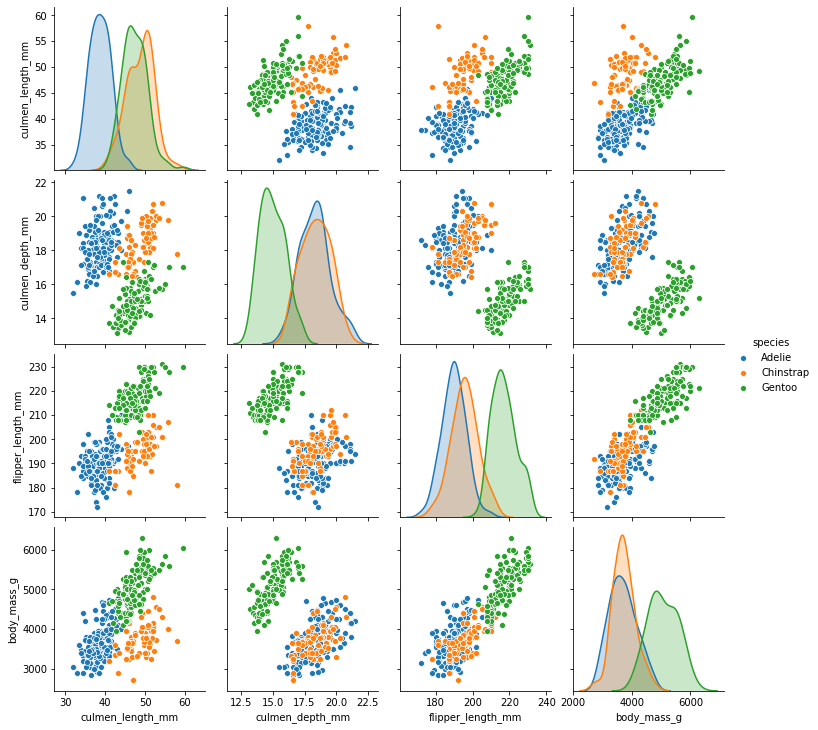

In [23]:
sns.pairplot(df_clean, hue="species")

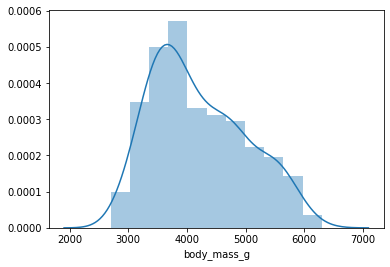

In [24]:
sns.distplot(df_clean['body_mass_g'])

### Step-3: Feature Extraction/Addition (optional):  
In this step, additional features can be added to the existing dataset. The existing features can be altered in a way that can better serve for training the underlying model. You can skip this step if you think there is no room for extracting/adding extra features.

In [45]:
features = df_clean.drop('species', axis=1)
response = df_clean[['species']]

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
features['sex'] = labelencoder.fit_transform(features['sex'])

# use Pandas get_dummies to encode island variable
features_encoded = pd.get_dummies(features, columns=['island'])

features_encoded.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,island_Biscoe,island_Dream,island_Torgersen
0,39.1,18.7,181,3750,1,0,0,1
1,39.5,17.4,186,3800,0,0,0,1
2,40.3,18.0,195,3250,0,0,0,1
4,36.7,19.3,193,3450,0,0,0,1
5,39.3,20.6,190,3650,1,0,0,1


### Step-4: Data Scaling (optional):  
Transform your data so that it fits within a specific scale. For example standardization or normalization. You can skip this step if you think your dataset does not contain features highly varying in magnitudes, units and range.

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
data_normalized = scaler.fit_transform(features_encoded)
features_normalized = pd.DataFrame(data_normalized, columns = features_encoded.columns.to_list())
features_normalized.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,island_Biscoe,island_Dream,island_Torgersen
0,0.254545,0.666667,0.152542,0.291667,1.0,0.0,0.0,1.0
1,0.269091,0.511905,0.237288,0.305556,0.0,0.0,0.0,1.0
2,0.298182,0.583333,0.389831,0.152778,0.0,0.0,0.0,1.0
3,0.167273,0.738095,0.355932,0.208333,0.0,0.0,0.0,1.0
4,0.261818,0.892857,0.305085,0.263889,1.0,0.0,0.0,1.0


### Step-5: Data Splitting:  
This step should start with creating two dataframes: response and features. Split these dataframes into train and test parts.

In [47]:
from sklearn.model_selection import train_test_split

result_list = train_test_split(features_encoded, response, test_size=0.3, random_state=22)
features_train, features_test, response_train, response_test = result_list

print("full df_clean:", df_clean.shape)
print("features_train:", features_train.shape)
print("features_test:", features_test.shape)
print("response_train:", response_train.shape)
print("response_test:", response_test.shape)

full df_clean: (342, 7)
features_train: (239, 8)
features_test: (103, 8)
response_train: (239, 1)
response_test: (103, 1)


### Step-6: Model Selection, Model Fitting and Model Evaluation:  
Choose an appropriate model that can be used for your problem. You can choose a model that is listed under a given problem group below. You are also free to choose another model that you are familiar with. Fit your train data to your model. Generate predictions over the test data and then evaluate your model by reporting appropriate accuracy metrics.

In [52]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 66)
classifier.fit(features_train, response_train)

response_pred = classifier.predict(features_test)
from sklearn.metrics import accuracy_score
print('Accuracy Score on test data: ', accuracy_score(y_true=response_test, y_pred=response_pred))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(response_test, response_pred)
print(cm)

Accuracy Score on test data:  1.0
[[39  0  0]
 [ 0 27  0]
 [ 0  0 37]]


C:\Users\nvanb\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Wow, on the first model I got 100% accuracy!

### Step-7: Report Feature Importance:  
You must report the feature importance results.

In [58]:
importance = classifier.feature_importances_
feature_names = features_encoded.columns.to_list()

feature_importance_df = pd.DataFrame(feature_names, columns=['features'])
feature_importance_df['importance'] = importance
feature_importance_df

,features,importance
0,culmen_length_mm,0.311460
1,culmen_depth_mm,0.148939
2,flipper_length_mm,0.250157
3,body_mass_g,0.128663
4,sex,0.005522
5,island_Biscoe,0.077795
6,island_Dream,0.053488
7,island_Torgersen,0.023976


### Step-8: Improve Results:  

Since I cannot imporove the accuracy, I will see if I can remove the least important features and keep a high accuracy.

The features `sex` and `island` don't have a very high importance. I will remove them and see if I can keep a high accuracy.  This could be important for applicability of the model, since it may not always be possible to determine the sex of a penguin in the field or which island the penguin may have come from if it were captured in the water.

In [59]:
# remove sex and island features
body_features = features.drop(['island','sex'], axis=1)

from sklearn.model_selection import train_test_split

result_list = train_test_split(body_features, response, test_size=0.3, random_state=22)
features_train, features_test, response_train, response_test = result_list

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 49)
classifier.fit(features_train, response_train)

response_pred = classifier.predict(features_test)
from sklearn.metrics import accuracy_score
print('Accuracy Score on test data: ', accuracy_score(y_true=response_test, y_pred=response_pred))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(response_test, response_pred)
print(cm)

Accuracy Score on test data:  0.9805825242718447
[[38  1  0]
 [ 1 26  0]
 [ 0  0 37]]


C:\Users\nvanb\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


In [60]:
# remove only sex feature
loc_features = features_encoded.drop(['sex'], axis=1)

from sklearn.model_selection import train_test_split

result_list = train_test_split(loc_features, response, test_size=0.3, random_state=22)
features_train, features_test, response_train, response_test = result_list

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 49)
classifier.fit(features_train, response_train)

response_pred = classifier.predict(features_test)
from sklearn.metrics import accuracy_score
print('Accuracy Score on test data: ', accuracy_score(y_true=response_test, y_pred=response_pred))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(response_test, response_pred)
print(cm)

Accuracy Score on test data:  0.9902912621359223
[[38  1  0]
 [ 0 27  0]
 [ 0  0 37]]


C:\Users\nvanb\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Without `sex` and `island` the model performance drops to 98% accuracy, while dropping only the `sex` variable produced 99% accuracy. While these two features are not very important for the overall performance of the model, they clearly provide the information necessary to completely classify species correctly.  

The first model was run with the encoded, but not normalized data. To see if data normalization makes a difference for this dataset I will try running the full model again with the normalized dataframe.

In [61]:
# compare importance of original with normalized

from sklearn.model_selection import train_test_split

result_list = train_test_split(features_normalized, response, test_size=0.3, random_state=22)
features_train, features_test, response_train, response_test = result_list

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 49)
classifier.fit(features_train, response_train)

response_pred = classifier.predict(features_test)
from sklearn.metrics import accuracy_score
print('Accuracy Score on test data: ', accuracy_score(y_true=response_test, y_pred=response_pred))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(response_test, response_pred)
print(cm)

Accuracy Score on test data:  1.0
[[39  0  0]
 [ 0 27  0]
 [ 0  0 37]]


C:\Users\nvanb\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


In [62]:
importance = classifier.feature_importances_
feature_names = features_encoded.columns.to_list()

feature_norm_importance_df = pd.DataFrame(feature_names, columns=['features'])
feature_norm_importance_df['importance_norm'] = importance
# add original importance values to the dataframe
feature_norm_importance_df['importance_full'] = feature_importance_df['importance']
feature_norm_importance_df

,features,importance_norm,importance_full
0,culmen_length_mm,0.311460,0.311460
1,culmen_depth_mm,0.148939,0.148939
2,flipper_length_mm,0.250157,0.250157
3,body_mass_g,0.128663,0.128663
4,sex,0.005522,0.005522
5,island_Biscoe,0.077795,0.077795
6,island_Dream,0.053488,0.053488
7,island_Torgersen,0.023976,0.023976


Using normalized ("norm") or un-normailzed ("full") dataset does not make a difference in model performance or feature importance.

***

## Part 2: Predict Body Mass (regression)

Now, I will use regression to predict `body_mass_g`. This is important because it is often difficult or impracticable to get body mass measurements in the field, but if these can be accurately predicted from the other body measurements that are easier to obtain we can still get an estimate on the mass of the penguin.

The data are all mostly prepared (I just need to rearrange some of the features to prepare it for regression) so I will start at **step 5** and preform all the steps combined together.  I will run several models together and see which one works best.

In [63]:
response_bmi = df_clean[['body_mass_g']]
# prepare new featrues df
features_bmi = features_encoded.drop('body_mass_g', axis=1)
features_bmi['species'] = df_clean['species']
features_bmi = pd.get_dummies(features_bmi, columns=['species'])


from sklearn.model_selection import train_test_split
result_list = train_test_split(features_bmi, response_bmi, test_size=0.3, random_state=22)
features_train, features_test, response_train, response_test = result_list

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn import metrics

# a) Choose models
models_list = [LinearRegression(),
               DecisionTreeRegressor(),
               RandomForestRegressor(), 
               XGBRegressor(), 
               CatBoostRegressor(silent=True),
               LGBMRegressor()] 

# model names in a list
model_names = ['Linear Regression',
               'Decision Tree', 
               'Random Forest', 
               'Extreme Gradient Boosting', 
               'Categorical Gradient Boosting',
               'Light Gradient Boosting Model']  


feature_names = features_bmi.columns.to_list()
feature_importance_df = pd.DataFrame(feature_names, columns=['features'])
MAE_list = []
MSE_list = []
RMSE_list = []

for model in range(len(models_list)):
    regressor = models_list[model]
    # b) Train the models using train part of the data
    regressor.fit(features_train, response_train)
    # c) Generate predictions over the test data
    response_pred = regressor.predict(features_test)
    # d) Calculate the associated metrics 
    MAE_list.append(round(metrics.mean_absolute_error(response_test, response_pred), 4))
    MSE_list.append(round(metrics.mean_squared_error(response_test, response_pred), 4))
    RMSE_list.append(round(np.sqrt(metrics.mean_squared_error(response_test, response_pred)), 4))
    # add IF statement for linear regression
    if model_names[model] == 'Linear Regression':
        importance = regressor.coef_[0].round(4)
    else:
        importance = regressor.feature_importances_   
    feature_importance_df[model_names[model]] = importance
     
result_dict = {'Model Name':model_names, 'MAE':MAE_list, 'MSE':MSE_list, 'RMSE':RMSE_list}

# e) Report the estimated metrics in a table for each model.
results_df = pd.DataFrame(result_dict)
results_df

C:\Users\nvanb\anaconda3\lib\site-packages\ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Model Name,MAE,MSE,RMSE
0,Linear Regression,234.6109,84485.2432,290.6635
1,Decision Tree,305.0971,146037.6214,382.1487
2,Random Forest,254.8058,101774.0461,319.0204
3,Extreme Gradient Boosting,296.9946,143090.6462,378.2732
4,Categorical Gradient Boosting,257.4707,105537.9985,324.8661
5,Light Gradient Boosting Model,264.3112,107590.2108,328.0095


Surprisingly, `LinearRegression()` had the lowest RMSE for this problem!  

I will run again with the normalized dataset so the coefficients will be easier to compare.

In [65]:
response_bmi_norm = features_normalized[['body_mass_g']]
# prepare new features df
features_bmi_norm = features_normalized.drop('body_mass_g', axis=1)
features_bmi_norm['species'] = df_clean['species']
features_bmi_norm = pd.get_dummies(features_bmi_norm, columns=['species'])


from sklearn.model_selection import train_test_split
result_list = train_test_split(features_bmi_norm, response_bmi_norm, test_size=0.3, random_state=22)
features_train, features_test, response_train, response_test = result_list

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn import metrics

# a) Choose models
models_list = [LinearRegression(),
               DecisionTreeRegressor(),
               RandomForestRegressor(), 
               XGBRegressor(), 
               CatBoostRegressor(silent=True),
               LGBMRegressor()] 

# model names in a list
model_names = ['Linear Regression',
               'Decision Tree', 
               'Random Forest', 
               'Extreme Gradient Boosting', 
               'Categorical Gradient Boosting',
               'Light Gradient Boosting Model']  


feature_names = features_bmi_norm.columns.to_list()
feature_importance_df_norm = pd.DataFrame(feature_names, columns=['features'])
MAE_list = []
MSE_list = []
RMSE_list = []

for model in range(len(models_list)):
    regressor = models_list[model]
    # b) Train the models using train part of the data
    regressor.fit(features_train, response_train)
    # c) Generate predictions over the test data
    response_pred = regressor.predict(features_test)
    # d) Calculate the associated metrics 
    MAE_list.append(round(metrics.mean_absolute_error(response_test, response_pred), 4))
    MSE_list.append(round(metrics.mean_squared_error(response_test, response_pred), 4))
    RMSE_list.append(round(np.sqrt(metrics.mean_squared_error(response_test, response_pred)), 4))
    # add Try statement for linear regression??
    if model_names[model] == 'Linear Regression':
        importance = regressor.coef_[0].round(4)
    else:
        importance = regressor.feature_importances_   
    feature_importance_df_norm[model_names[model]] = importance
     
result_dict_norm = {'Model Name':model_names, 'MAE':MAE_list, 'MSE':MSE_list, 'RMSE':RMSE_list}

# e) Report the estimated metrics in a table for each model.
results_df_norm = pd.DataFrame(result_dict_norm)
results_df_norm

C:\Users\nvanb\anaconda3\lib\site-packages\ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Model Name,MAE,MSE,RMSE
0,Linear Regression,0.0689,0.0069,0.0833
1,Decision Tree,0.0879,0.0122,0.1107
2,Random Forest,0.0721,0.0080,0.0897
3,Extreme Gradient Boosting,0.0779,0.0098,0.0991
4,Categorical Gradient Boosting,0.0722,0.0082,0.0906
5,Light Gradient Boosting Model,0.0763,0.0088,0.0937


In [66]:
# normalixed coefficients
feature_importance_df_norm.sort_values('Linear Regression', ascending=False)

,features,Linear Regression,Decision Tree,Random Forest,Extreme Gradient Boosting,Categorical Gradient Boosting,Light Gradient Boosting Model
2,flipper_length_mm,0.3724,0.701870,0.589378,0.315988,24.420028,255
0,culmen_length_mm,0.1877,0.058173,0.059101,0.010074,16.709640,261
3,sex,0.1129,0.145650,0.101239,0.597369,21.829414,42
9,species_Gentoo,0.0464,0.000296,0.161117,0.000304,15.554764,12
1,culmen_depth_mm,0.0315,0.081320,0.069968,0.022186,14.881382,189
4,island_Biscoe,0.0139,0.004783,0.004460,0.021640,2.558500,29
6,island_Torgersen,-0.0056,0.002671,0.001553,0.002411,0.698277,4
5,island_Dream,-0.0082,0.005099,0.007309,0.006720,1.634224,13
7,species_Adelie,-0.0903,0.000000,0.001503,0.000064,0.891739,4
8,species_Chinstrap,-0.1955,0.000138,0.004372,0.023244,0.822032,9


In [67]:
# standard coefficients
feature_importance_df.sort_values('Decision Tree', ascending=False)

,features,Linear Regression,Decision Tree,Random Forest,Extreme Gradient Boosting,Categorical Gradient Boosting,Light Gradient Boosting Model
9,species_Gentoo,783.9382,0.673141,0.537446,0.979852,25.331751,12
3,sex,382.0401,0.167582,0.115768,0.006714,21.390654,39
0,culmen_length_mm,20.2851,0.056674,0.057483,0.000228,14.789547,284
2,flipper_length_mm,15.1277,0.044261,0.201889,0.003555,19.313717,250
1,culmen_depth_mm,74.9827,0.041825,0.075313,0.000306,14.063112,188
5,island_Dream,2.0294,0.005233,0.003623,0.000535,1.582017,14
4,island_Biscoe,-0.3278,0.004790,0.004097,0.000432,1.622985,20
7,species_Adelie,-235.6423,0.004006,0.001104,0.001050,0.585636,3
6,island_Torgersen,-1.7016,0.002479,0.001798,0.000143,0.561215,2
8,species_Chinstrap,-548.2960,0.000008,0.001479,0.007186,0.759366,12


Looking at the normalized linear regression coeffiecients we can see that, again, both `flipper_length` and `culmen_length` play a large role in predicting `body_mass`. This time, `sex` and `species` played a larger role since there is some sexual dimorphism in penguins, and the different species showed different size distributions as well; however, `island` still was not very important in the prediction   

The original, standard (i.e. un-normalized) metrics are easier to interpret. All other things being held constant, males are generally 400g larger than females, an increase of 1mm flipper length will increase body mass by 15g, an increase of 1mm culmen length will increase body mass by 20g, and an increase of 1mm culmen depth will increase body mass by 75g.

## Conclusion

